TODO:
    siflis
    HIV tratamento e controle
    grupos proximos: idade
    taxas de crescimento
    
ideia: baseado em um modelo SIR calcular o valor esperado de numero de contaminados em 2018. 
A diferença entre o valor esperado e o atual seria 

# HIV prevention policy: an econometric evaluation
#### Since 2018,  a medication that prevents hiv indections has been distributed in Brazil.

#### Medication is available to groups historically vunerable to HIV: sex workers, transexual women and homossexual man.

# 3 counterfactuals:
#### Treated and non-treated groups in the same city/region: 
* Outcome variable: new infections after treatment started
* Treated: homossexual group
* Control: heterossexual group

#### The homossexual group in treated and non-treated cities

#### New HIV cases and Hepatites cases in treated group

In [347]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.rcParams["figure.figsize"] = [4,3]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
pd.set_option('display.max_columns', 500)
sns.set_style("whitegrid")
plt.style.use('./graph_config.mplstyle')

HET_COLOR = "#00A4CCFF"# "#00A4CCFF"
GAY_COLOR = "#F95700FF" # "#F95700FF"
palette_hetgay = [HET_COLOR,GAY_COLOR]

label_het = "Heterossexual (Control)"
label_gay = "Homossexual man (Treated)"
order_hetgay = [label_het,
                label_gay]

SINGLE_COLOR="#b3c6ff"
BINNED_COLOR="#b3c6ff"

filter_years = [2014,2015, 2016,2017,2018,2019,2020,2021]

#### useful functions

In [80]:
def melt_groups(df, cols, id_vars=["name","code","year","treated"]):
    # Example: melt_groups(cases, ["hiv_m","hiv_f"])
    return (df.melt(id_vars=id_vars,
               value_vars=cols,
               var_name="group")
          .rename(columns={"variable":"code",
                           "value":"cases"}))

def binned_data(df, var, dict_hist):
    labels = []
    values = []
    for label,interval in dict_hist.items():
        start = interval[0]
        end = interval[1]
        query = f"{var} >= {start} & {var} <= {end}"
        labels.append(label)
        value = df[label] = df.query(query).shape[0]
        values.append(value)

    return pd.DataFrame({"labels":labels, "values":values})

#### outcome variable

##### cities

In [445]:
cases = pd.read_csv("data/cases_cleaned.csv")
cities = cases.query("region_type == 'city' ")
cities = cities.sort_values(['code','year'])
cities = cities.set_index(['code','year','name'])

def pct_change_2(series):
    return series.pct_change(2)

outcomes = (cities
            #.set_index(['code','year','name'])
    .groupby(["code"])
    .agg({"hiv_total": "pct_change",
          "hep_b_total":"pct_change",
          "hep_b_m":"pct_change",
          "hep_b_f":"pct_change",
          "hiv_homo":"pct_change",
          "hiv_het":"pct_change",
          "hiv_f":"pct_change"}))

outcomes = outcomes.add_suffix('_pct_change')
cities = pd.concat([cities, outcomes], axis=1).reset_index().set_index("code")

cities["hiv_het_pct_change_follow_year"] = cities.shift(-1)["hiv_het_pct_change"]
cities["hiv_homo_pct_change_follow_year"] = cities.shift(-1)["hiv_homo_pct_change"]

cities.to_csv("data/cities_with_outcome.csv", mode="w")

##### regions

In [418]:
regions = pd.read_csv("data/regions.csv")

regions = regions.set_index(['region_code','year','region_name'])
outcomes_region = (regions
            #.set_index(['code','year','name'])
        .groupby("region_code")
        .agg({
             "hiv_total":"pct_change",
             "hiv_homo":"pct_change",
             "hiv_het":"pct_change",
             "hiv_bi":"pct_change",
             "hiv_f":"pct_change",
             "hep_b_total":"pct_change",
             "hep_b_m":"pct_change",
             "hep_b_f":"pct_change",
             "following":"pct_change",
             "loss_of_follow":"pct_change",
             "new_users":"pct_change"
})
)
#regions = regions.reset_index().set_index("region_code")

outcomes_region = outcomes_region.add_suffix('_pct_change')
regions = pd.concat([regions, outcomes_region], axis=1).reset_index().set_index("region_code")

regions["hiv_het_pct_change_follow_year"] = regions.shift(-1)["hiv_het_pct_change"]
regions["hiv_homo_pct_change_follow_year"] = regions.shift(-1)["hiv_homo_pct_change"]

#### Data description

In [423]:
cities.loc[530010][["year","name","hiv_het","hiv_homo","new_users","pct_new_users","hiv_het_pct_change","hiv_homo_pct_change"]]

,year,name,hiv_het,hiv_homo,new_users,pct_new_users,hiv_het_pct_change,hiv_homo_pct_change
code,,,,,,,,
530010,2013,Brasília,125,222,NaN,NaN,NaN,NaN
530010,2014,Brasília,79,163,NaN,NaN,-0.368000,-0.265766
530010,2015,Brasília,54,158,NaN,NaN,-0.316456,-0.030675
530010,2016,Brasília,57,135,NaN,NaN,0.055556,-0.145570
530010,2017,Brasília,64,139,NaN,NaN,0.122807,0.029630
530010,2018,Brasília,41,132,212.0,1.606061,-0.359375,-0.050360
530010,2019,Brasília,43,134,129.0,0.962687,0.048780,0.015152
530010,2020,Brasília,29,116,-11.0,0.000000,-0.325581,-0.134328
530010,2021,Brasília,45,88,312.0,3.545455,0.551724,-0.241379


#### barplot count homossexual x het

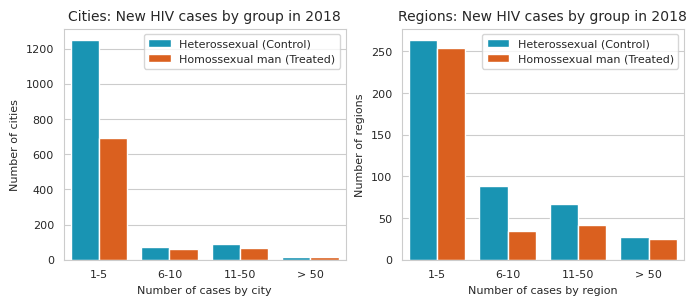

In [117]:
dict_hist = {
    "1-5":  [1,5],
    "6-10": [6,10],
    "11-50":[11,50],
    "> 50": [50,100000]
}

het_count_hist = binned_data(cities.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(cities.query("year == 2018"), "hiv_homo", dict_hist)

het_count_hist["group"] = label_het
gay_count_hist["group"] = label_gay


hist_count_cities = pd.concat([het_count_hist, gay_count_hist])

##### CITIES

fig, ax = plt.subplots(figsize=(8,3))
plt.subplot(1, 2, 1)
g = sns.barplot(hist_count_cities,
             x="labels", y="values", hue="group",
                palette=palette_hetgay,
                hue_order=order_hetgay)

plt.title("Cities: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of cities")
plt.xlabel("Number of cases by city")


##### REGION

plt.subplot(1, 2, 2)
het_count_hist = binned_data(regions.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(regions.query("year == 2018"), "hiv_homo", dict_hist)

het_count_hist["group"] = label_het
gay_count_hist["group"] = label_gay

hist_count_region = pd.concat([het_count_hist, gay_count_hist])

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(hist_count_region,
             x="labels", y="values", hue="group",
             palette=palette_hetgay,
             hue_order=order_hetgay)

plt.title("Regions: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of regions")
plt.xlabel(f"Number of cases by region")

plt.savefig("results_graphs/new_cases_by_city_region.png", 
               bbox_inches='tight')
plt.show()

#### New users by year

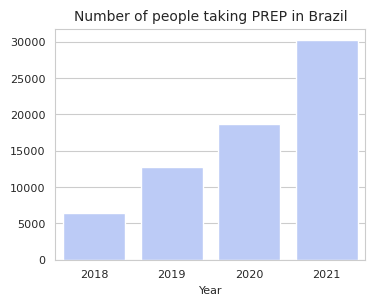

In [21]:
from numpy import count_nonzero
ax = sns.barplot(x="year", y="following",
                 data=cases.query("year in [2018,2019,2020,2021]"),
                 estimator=np.sum, color=SINGLE_COLOR)
plt.title("Number of people taking PREP in Brazil")
plt.xlabel("Year")
plt.ylabel("")

plt.savefig("results_graphs/new_cases_by_city_region.png", 
               bbox_inches='tight')
plt.show()

### Number of cities by level of treatment by year

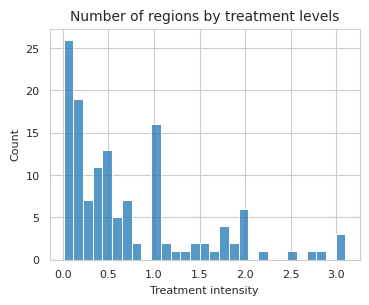

In [429]:
sns.histplot(cities.query("year == 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,3.1,30))
plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

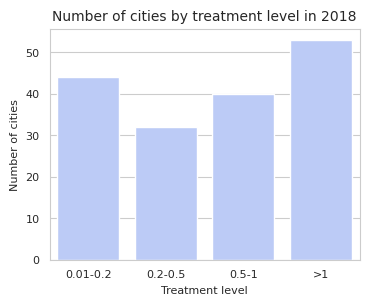

In [351]:
#cases_scatter = cities.query(f"""year == 2018 & pct_following > 0.01 & pct_following < 5 & hiv_homo_pct_change < 2 & hiv_homo > 5""")
#sns.scatterplot(cases_scatter,
#                x="hiv_homo",
#                y="pct_following")

dict_hist = {
    "0.01-0.2": [0.01,0.2],
    "0.2-0.5": [0.2,0.5],
    "0.5-1": [0.5,1],
    ">1": [1,10],
}

cities_by_treat_level = binned_data(cities.query("year == 2018"), "pct_new_users", dict_hist)

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(cities_by_treat_level,
             x="labels", y="values",color=BINNED_COLOR)

plt.title("Number of cities by treatment level in 2018",fontsize=10)
plt.ylabel("Number of cities")
plt.xlabel(f"Treatment level")

plt.savefig("results_graphs/cities_by_treat_level.png", 
               bbox_inches='tight', )
plt.show()

### Number of regions by level

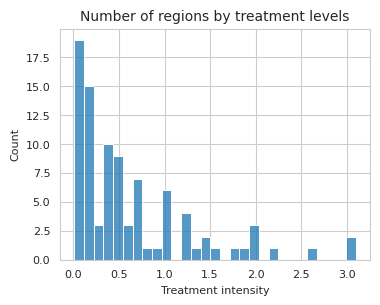

In [428]:
sns.histplot(regions.query("year == 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,3.1,30))
plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

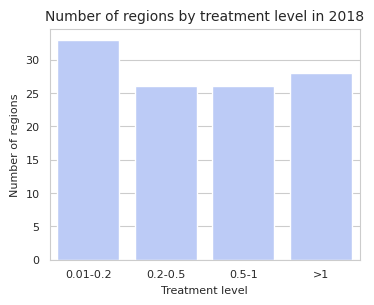

In [350]:
dict_hist = {
    "0.01-0.2": [0.01,0.2],
    "0.2-0.5": [0.2,0.5],
    "0.5-1": [0.5,1],
    ">1": [1,10],
}

regions_by_treat_level = binned_data(regions.query("year == 2018"), "pct_new_users", dict_hist)

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(regions_by_treat_level,
             x="labels", y="values",color=BINNED_COLOR)

plt.title("Number of regions by treatment level in 2018",fontsize=10)
plt.ylabel("Number of regions")
plt.xlabel(f"Treatment level")

plt.savefig("results_graphs/cities_by_treat_level.png", 
               bbox_inches='tight', )
plt.show()

### Scatter: City sizes by treatment levels

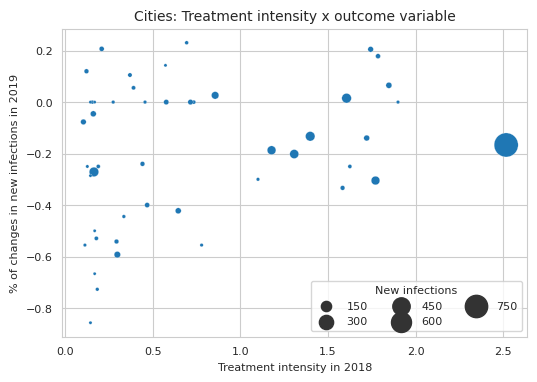

In [433]:
cases_scatter = cities.query(f"""year == 2018 & pct_following > 0.1 & pct_following < 3 & hiv_homo_pct_change_follow_year < 0.25 & hiv_homo > 5""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="hiv_homo_pct_change_follow_year",
                size="hiv_homo",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Cities: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("results_graphs/cities_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

### Scatter: regions by treatment levels

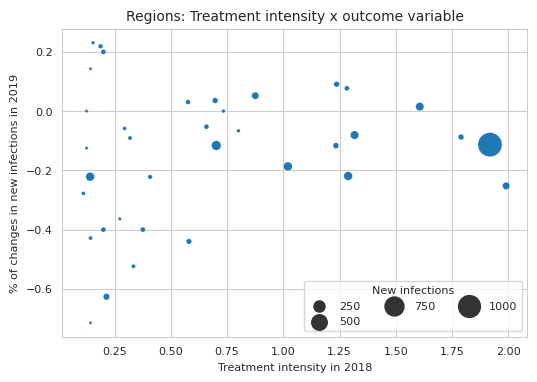

In [434]:
cases_scatter = regions.query(f"""year == 2018 & pct_following > 0.1 & pct_following < 3 & hiv_homo_pct_change_follow_year < 0.25 & hiv_homo > 5""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="hiv_homo_pct_change_follow_year",
                size="hiv_homo",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Regions: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("results_graphs/regions_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

## PARALLEL TRENDS

##### define treatment

In [221]:
lower = 0.2
upper = 0.7
titles_same_city = [f"Treated cities ({lower} < pct_treat < {upper})",
                    f"Treated cities (pct_treat > {upper})"]

# cities
cities["treated"] = 0

filter18_1 = cities[(cities["year"] == 2018) & (cities["pct_new_users"].between(lower,upper))].index
cities.loc[filter18_1, "treated"] = 1

filter18_2 = cities[(cities["year"] == 2018) & (cities["pct_new_users"] > upper)].index
cities.loc[filter18_2, "treated"] = 2

sizes_same_city=[len(cities.query("year == 2018 & treated == 1 ")),
                 len(cities.query("year == 2018 & treated == 2 "))]

# regions
lower = 0.2
upper = 0.7
titles_same_city = [f"Treated regions ({lower} < pct_treat < {upper})",
                    f"Treated regions (pct_treat > {upper})"]

regions["treated"] = 0
filter18_1 = regions[(regions["year"] == 2018) & (regions["pct_new_users"].between(lower,upper))].index
regions.loc[filter18_1, "treated"] = 1

filter18_2 = regions[(regions["year"] == 2018) & (regions["pct_new_users"] > upper)].index
regions.loc[filter18_2, "treated"] = 2

sizes_same_region=[len(regions.query("year == 2018 & treated == 1 ")),
                 len(regions.query("year == 2018 & treated == 2 "))]



##### city: homossexual x heterossexual

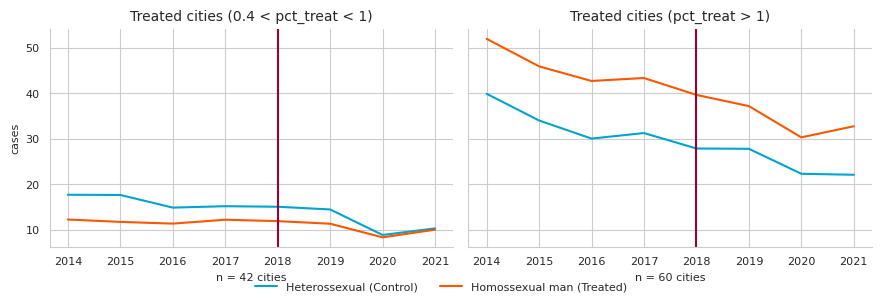

In [210]:
#graph = cities.query(f"hiv_homo > 1 & year in {filter_years}")
graph = cities.query(f"treated.isin([1,2]) ")
graph = graph.query(f"year in {filter_years}")

graph = melt_groups(graph.reset_index(),
                    ["hiv_het","hiv_homo"])

graph.loc[graph["group"] == "hiv_het","group"]  = label_het
graph.loc[graph["group"] == "hiv_homo","group"]  = label_gay

g = sns.relplot(graph.query("treated.isin([1,2])"),
                x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5,
                 palette=palette_hetgay,
                 hue_order=order_hetgay)
plt.xticks(filter_years, fontsize=8)

for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_city):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} cities")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)
plt.savefig("results_graphs/parallel_trends_treated_cities.png", 
               bbox_inches='tight')
plt.show()

##### region: homossexual x heterossexual

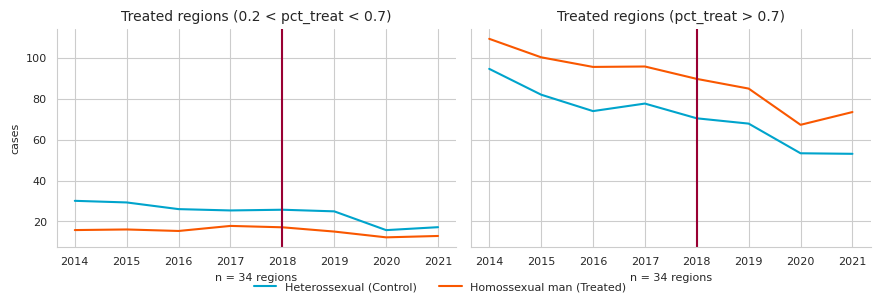

In [224]:
graph = regions.query(f"treated.isin([1,2]) ")
graph = graph.query(f"year in {filter_years}")

graph = melt_groups(graph.reset_index(),
                    ["hiv_het","hiv_homo"],
                   id_vars=["region_name","region_code","treated","year"])

graph.loc[graph["group"] == "hiv_het","group"]  = label_het
graph.loc[graph["group"] == "hiv_homo","group"]  = label_gay

g = sns.relplot(graph.query("treated.isin([1,2])"),
                x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5,
                 palette=palette_hetgay,
                 hue_order=order_hetgay)

plt.xticks(filter_years, fontsize=8)
for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_region):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} regions")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)

plt.savefig("results_graphs/parallel_trends_treated_regions.png", 
               bbox_inches='tight')
plt.show()

### Counterfactual 2: treated and non-treated cities

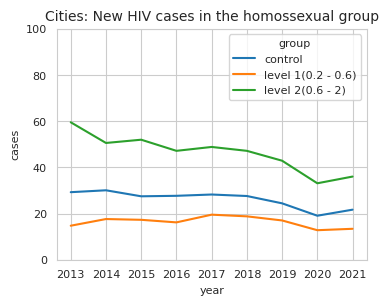

In [440]:
lower = 0.2
middle = 0.6
upper = 2

# cities
cities["treated"] = 0

filter18_1 = cities[(cities["year"] == 2018) & (cities["pct_new_users"].between(lower,middle))].index
cities.loc[filter18_1, "treated"] = 1

filter18_2 = cities[(cities["year"] == 2018) & (cities["pct_new_users"].between(middle,upper))].index
cities.loc[filter18_2, "treated"] = 2

filter_non_treated = cities[(cities["year"] == 2018) & (cities["hiv_homo"] > 5) & (cities["treated"] == 0)].index
cities_non_treated = cities.loc[filter_non_treated]

filter_treated_1 = cities[(cities["year"] == 2018) & (cities["hiv_homo"] > 5) & (cities["treated"] == 1)].index
cities_treated_1 = cities.loc[filter_treated_1]

filter_treated_2 = cities[(cities["year"] == 2018) & (cities["hiv_homo"] > 5) & (cities["treated"] == 2)].index
cities_treated_2 = cities.loc[filter_treated_2]

cities_non_treated["cases"] = cities_non_treated["hiv_homo"]
cities_non_treated["group"] = "control"
cities_non_treated = cities_non_treated.set_index('year', append=True)
#cities_non_treated["group"] = #"Homossexual group in control cities"

cities_treated_1["cases"] = cities_treated_1["hiv_homo"]
cities_treated_1["group"] = "level 1(0.2 - 0.6)"
cities_treated_1 = cities_treated_1.set_index('year', append=True)
#cities_treated_1["group"] = #"Homossexual group in treated cities (0.2 < % treat < 0.7)"

cities_treated_2["cases"] = cities_treated_2["hiv_homo"]
cities_treated_2["group"] = "level 2(0.6 - 2)"
cities_treated_2 = cities_treated_2.set_index('year', append=True)
#cities_treated_2["group"] = "Homossexual group in treated cities (treat > 0.7)"


cities_treated_control = pd.concat([cities_non_treated[["cases","group"]],
           cities_treated_1[["cases","group"]],
           cities_treated_2[["cases","group"]] ]
          ,axis=0).reset_index()

plt.title("")
g.axvline(x=2018, color='#990033', linestyle='-')
g = sns.lineplot(cities_treated_control,
                x="year", y="cases", 
                errorbar=None, hue="group")
plt.title("Cities: New HIV cases in the homossexual group")
plt.ylim([0,100])
plt.show()

##### gays: treated and non-treated regions

(0.0, 120.0)

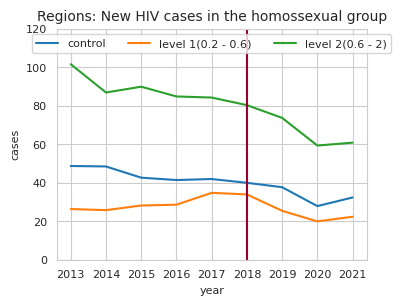

In [444]:
lower = 0.2
middle = 0.6
upper = 2

# cities
regions["treated"] = 0

filter18_1 = regions[(regions["year"] == 2018) & (regions["pct_new_users"].between(lower,middle))].index
regions.loc[filter18_1, "treated"] = 1

filter18_2 = regions[(regions["year"] == 2018) & (regions["pct_new_users"].between(middle,upper))].index
regions.loc[filter18_2, "treated"] = 2

filter_non_treated = regions[(regions["year"] == 2018) & (regions["hiv_homo"].between(10,500)) & (regions["treated"] == 0)].index
cities_non_treated = regions.loc[filter_non_treated]

filter_treated_1 = regions[(regions["year"] == 2018) & (regions["hiv_homo"].between(10,500)) & (regions["treated"] == 1)].index
cities_treated_1 = regions.loc[filter_treated_1]

filter_treated_2 = regions[(regions["year"] == 2018) & (regions["hiv_homo"].between(10,500)) & (regions["treated"] == 2)].index
cities_treated_2 = regions.loc[filter_treated_2]

cities_non_treated["cases"] = cities_non_treated["hiv_homo"]
cities_non_treated["group"] = "control"
cities_non_treated = cities_non_treated.set_index('year', append=True)
#cities_non_treated["group"] = #"Homossexual group in control cities"

cities_treated_1["cases"] = cities_treated_1["hiv_homo"]
cities_treated_1["group"] = "level 1(0.2 - 0.6)"
cities_treated_1 = cities_treated_1.set_index('year', append=True)
#cities_treated_1["group"] = #"Homossexual group in treated cities (0.2 < % treat < 0.7)"

cities_treated_2["cases"] = cities_treated_2["hiv_homo"]
cities_treated_2["group"] = "level 2(0.6 - 2)"
cities_treated_2 = cities_treated_2.set_index('year', append=True)
#cities_treated_2["group"] = "Homossexual group in treated cities (treat > 0.7)"

cities_treated_control = pd.concat([cities_non_treated[["cases","group"]],
           cities_treated_1[["cases","group"]],
           cities_treated_2[["cases","group"]] ]
          ,axis=0).reset_index()

g = sns.lineplot(cities_treated_control,
                x="year", y="cases", 
                errorbar=None, hue="group")
g.axvline(x=2018, color='#990033', linestyle='-')
plt.title("Regions: New HIV cases in the homossexual group")
sns.move_legend(g, "upper center", title="",fontsize=8, ncol=3)
plt.ylim([0,120])

# Estimation

### Model 1 (pre-covid): binary treatment version: two-way fixed effects

$\Delta_{i_{t+1}} = \beta treat * post + X_i + \sigma_i + \tau_t + \epsilon_i $

$\Delta_{i_{t+1}}$: variation in the % of cases for city i in year t+1

$ treat $: indicator if in a city i, treatment was above a certain threshold

$X_i$: controls: (city characteristics, health service indicators)

$\sigma_i$: city/region FE

$\tau_t$: year FE

### Model 2 (pre and postcovid): continuous treatment version

# Results: nothing significant



_

# Issues for identification:
#### selection into treatment: bigger cities offer more treatment
#### big confounder: covid



_

# Issues for estimation:
#### small sample
#### continous treatment
#### dynamic effects
#### for binary treatment: establishing the threshold
#### how to properly weight city sizes



_

# Key takeaway:
##### The ammount of treatment was not enough to have an impact in the reduction of cases in the treatment group



_

# Contributions:
#### Dataset for future research
#### This policy was the main innovation in the prevention of HIV in the past decade. This paper is first time it is evaluated as an observational study with
#### If time allows: python package for continuous treatment effect estimation (Callaway/Sant'anna/Goodman-Bacon, Chaisemartin and d'haultfoeuille



_

# Sidenote
#### All results are on github and easily reproducible



_

# TODO:
* WRITE
* Add controls
* Account for old HIV cases
* Think of weighting/matching
* Try the hepatites cases as a counterfactual
* Try continous treatment estimation